In [15]:
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
seq_dim=(6,6)

In [16]:
import torch

import seaborn as sns

In [17]:
ising_data = np.load("data/ising-latt6x6-T4.0/latt6x6/buffer-S3.60.npy")
print(ising_data.shape)

(1000000, 36)


(100000, 36)


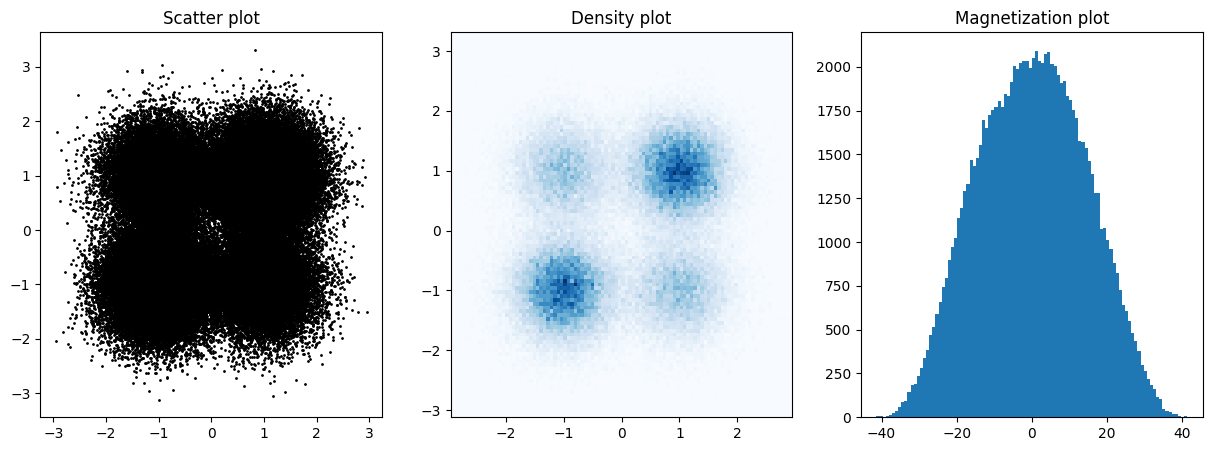

In [18]:

def sample_batch(size, noise=0.5):
    idx = np.random.choice(np.arange(len(ising_data)), size=size)
    x = ising_data[idx]
    add_noise = np.random.normal(0, noise, size=x.shape)
    return x[:]+add_noise
# Plot it
data = sample_batch(10**5)
print(data.shape)
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
axes[0].set_title('Scatter plot')
axes[0].plot(data[:,0], data[:,1],'ko',markersize=1)

axes[1].set_title('Density plot')
axes[1].hist2d(data[:,0], data[:,1],bins=100, cmap='Blues')

axes[2].set_title('Magnetization plot')
axes[2].hist(data.sum(-1),bins=100)
plt.show()

In [19]:
import torch.autograd as autograd

def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian

In [20]:
def dsm_loss(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

model_psi = nn.Sequential(
    nn.Linear(36, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer = optim.Adam(model_psi.parameters(), lr=3e-3)

l_curve = []
print('[Training step, loss value]')
for t in range(5000):
    dataset = torch.tensor(sample_batch(10**4)).float() 
    # Compute the loss.
    loss = dsm_loss(model_psi, dataset, sigma=0.5) # 注意：改动是这里的sigma
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 500) == 0):
        print([t,loss.item()])

[Training step, loss value]
[0, 74.87323760986328]
[500, 58.217899322509766]
[1000, 58.104774475097656]
[1500, 57.92494201660156]
[2000, 58.027217864990234]
[2500, 57.92472457885742]
[3000, 57.2273063659668]
[3500, 55.933738708496094]
[4000, 54.86873245239258]
[4500, 54.00270462036133]


In [30]:

print('[Training step, loss value]')
for t in range(5000,10000):
    dataset = torch.tensor(sample_batch(10**4)).float() 
    # Compute the loss.
    loss = dsm_loss(model_psi, dataset, sigma=0.5) # 注意：改动是这里的sigma
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 500) == 0):
        print([t,loss.item()])

[Training step, loss value]
[5000, 65.61111450195312]
[5500, 52.432254791259766]
[6000, 52.21204376220703]
[6500, 51.9735221862793]
[7000, 51.770469665527344]
[7500, 51.62513732910156]
[8000, 51.65281295776367]
[8500, 50.928062438964844]
[9000, 51.16548538208008]
[9500, 50.82039260864258]


In [ ]:
l_curve_ism = np.array(l_curve)
plt.plot(l_curve_ism[:,0],l_curve_ism[:,1])
plt.xlabel('Training Step')
plt.ylabel('ISM Loss Value')
plt.show()

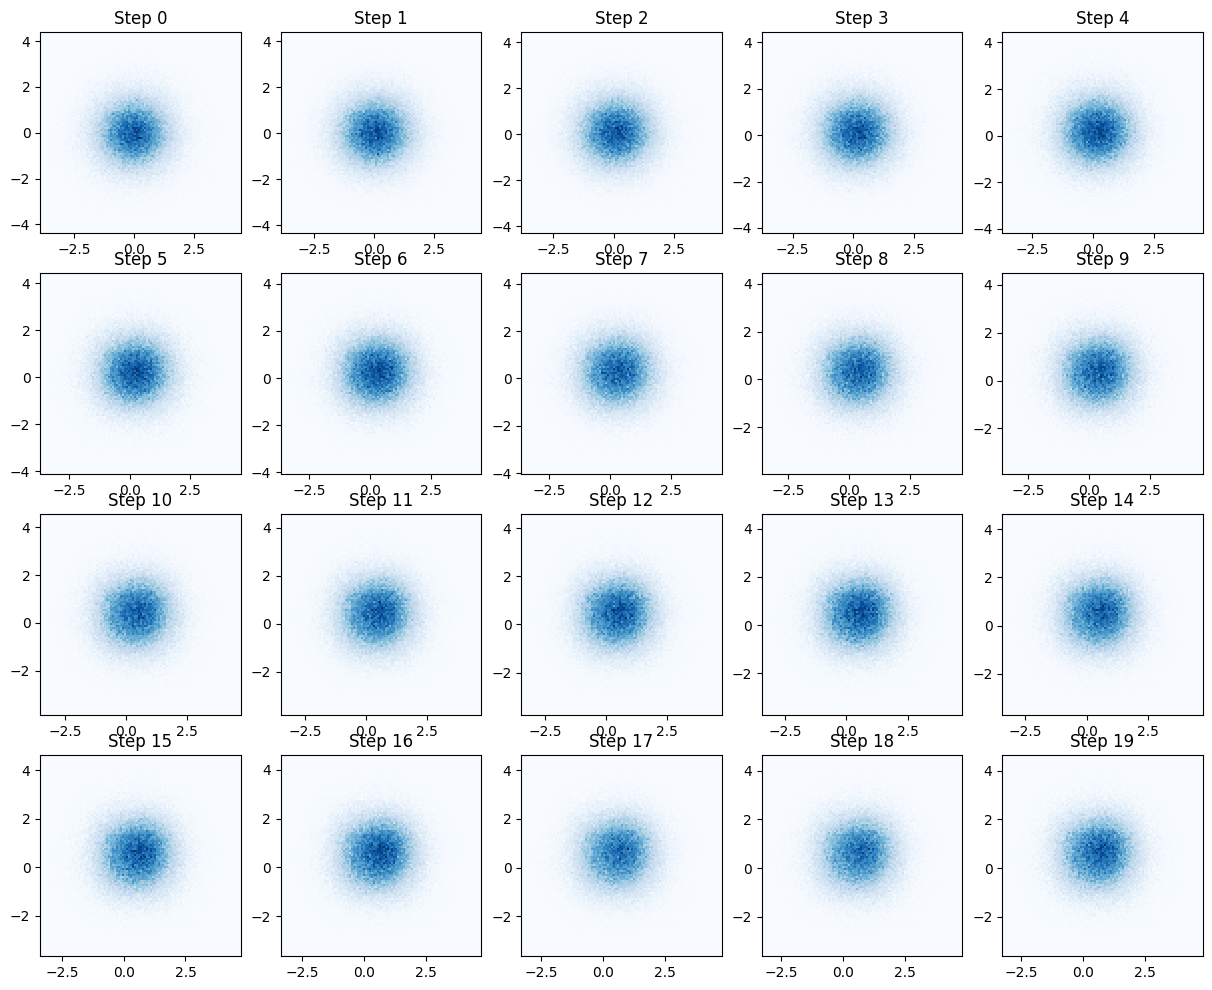

In [34]:
n_steps=19
eps=1e-2
decay=.9
temperature=1.0

xx =  torch.normal(0, 1, size=(10**5,36))
xx_t = []
xx_t.append(xx.detach().numpy())

for ii in range(n_steps):
    z_t = torch.rand(xx.size())
    xx = xx + (eps / 2) * model_psi(xx) + (np.sqrt(eps) * temperature * z_t)
    eps *= decay
    xx_t.append(xx.detach().numpy())
xx_t = np.array(xx_t)

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(15, 12))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues')
plt.show()

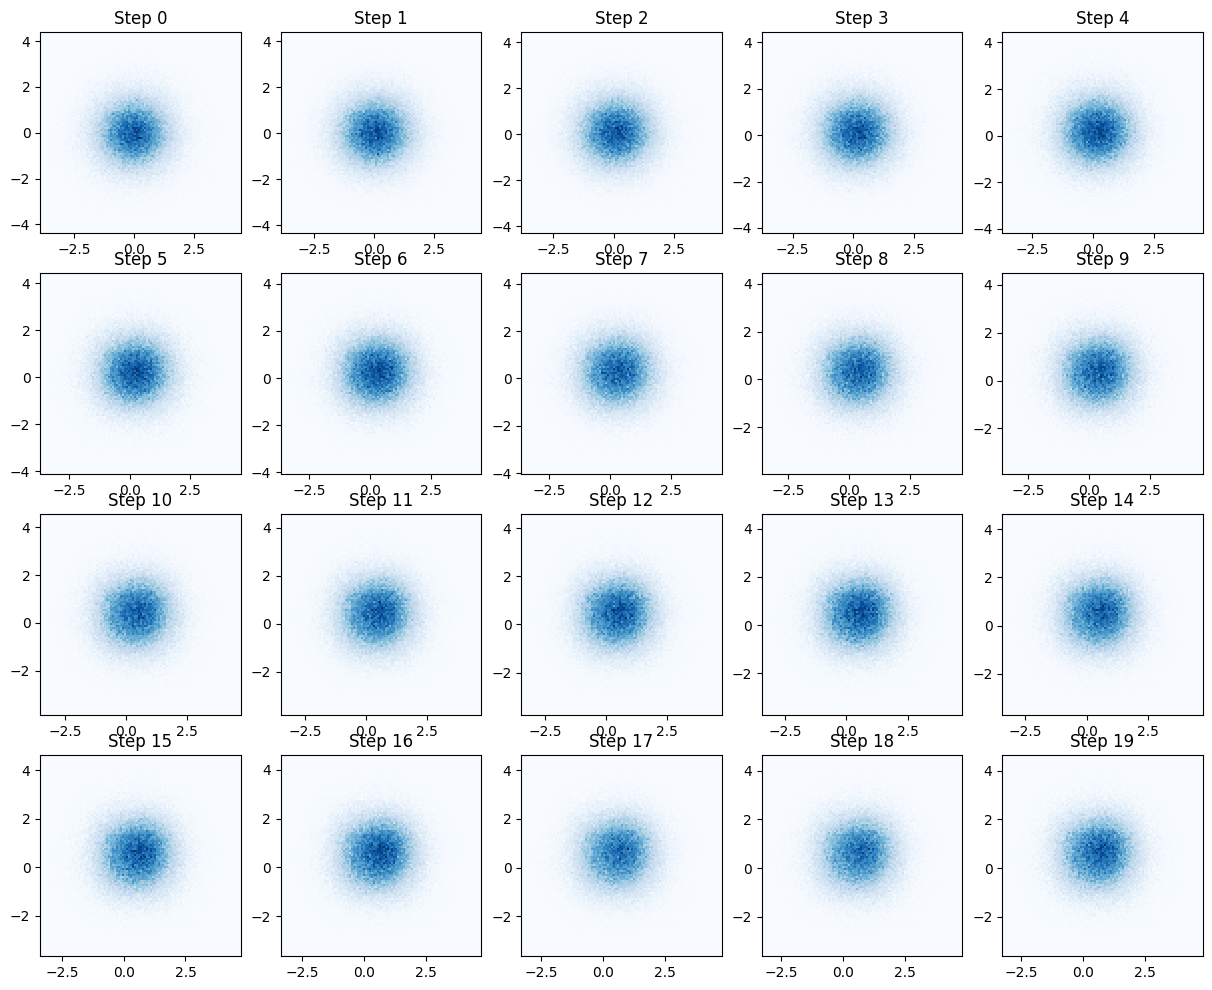

In [35]:

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(15, 12))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues')
plt.show()

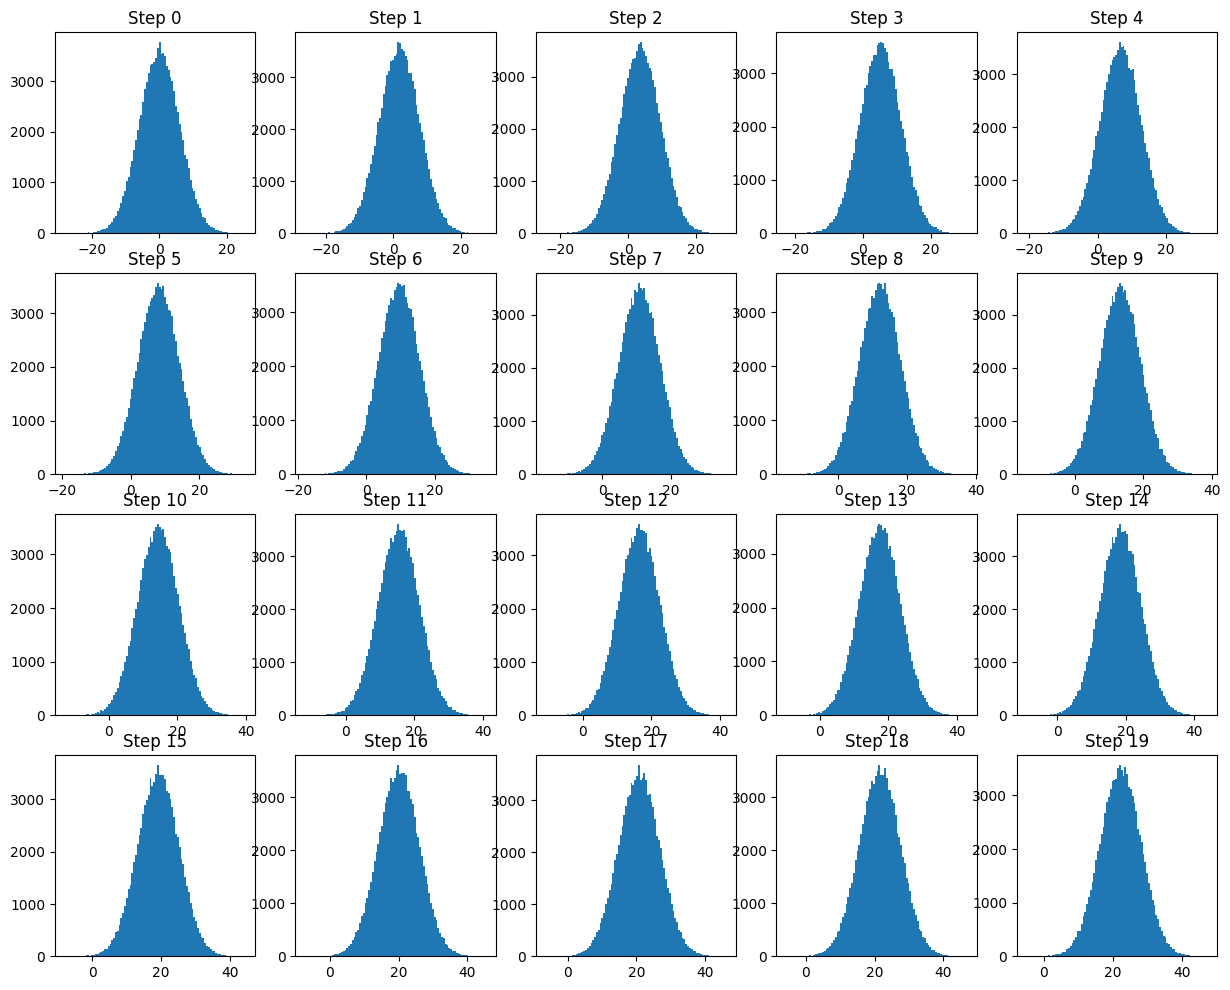

In [36]:

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(15, 12))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(xx_t[ii].sum(-1),bins=100)
plt.show()